GitHub Repository: https://github.com/hasanelahi7/ind320-assignment3.git
Streamlit App: https://ind320-assignment3-cuu9kwuwu5kfv8smrmyxge.streamlit.app/

In [2]:
%pip install requests pandas matplotlib

import pandas as pd
import requests
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


Note: you may need to restart the kernel to use updated packages.


In [3]:
cities = pd.DataFrame([
    # priceArea, city,           latitude,  longitude
    ["NO1",      "Oslo",         59.9139,   10.7522],
    ["NO2",      "Kristiansand", 58.1467,    7.9956],
    ["NO3",      "Trondheim",    63.4305,   10.3951],
    ["NO4",      "Tromsø",       69.6492,   18.9553],
    ["NO5",      "Bergen",       60.3913,    5.3221],
], columns=["priceArea","city","latitude","longitude"])

cities


,priceArea,city,latitude,longitude
0,NO1,Oslo,59.9139,10.7522
1,NO2,Kristiansand,58.1467,7.9956
2,NO3,Trondheim,63.4305,10.3951
3,NO4,Tromsø,69.6492,18.9553
4,NO5,Bergen,60.3913,5.3221


In [4]:
def fetch_open_meteo_era5(lat, lon, year,
                          hourly=("temperature_2m","precipitation")) -> pd.DataFrame:
    """
    Download ERA5 hourly reanalysis from Open-Meteo for a full year.
    Returns a DataFrame with 'time' (UTC) and selected hourly variables.
    """
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude":  lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date":   f"{year}-12-31",
        "hourly":     ",".join(hourly),
        "timezone":   "UTC",
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    js = r.json()
    df = pd.DataFrame(js["hourly"])
    df["time"] = pd.to_datetime(df["time"], utc=True)
    return df


In [5]:
bergen = cities[cities.city=="Bergen"].iloc[0]
wx_bergen_2019 = fetch_open_meteo_era5(bergen.latitude, bergen.longitude, 2019)
wx_bergen_2019.head()


,time,temperature_2m,precipitation
0,2019-01-01 00:00:00+00:00,5.8,0.2
1,2019-01-01 01:00:00+00:00,6.1,0.7
2,2019-01-01 02:00:00+00:00,6.3,0.5
3,2019-01-01 03:00:00+00:00,5.8,1.1
4,2019-01-01 04:00:00+00:00,5.7,0.7


Text(0, 0.5, 'mm')

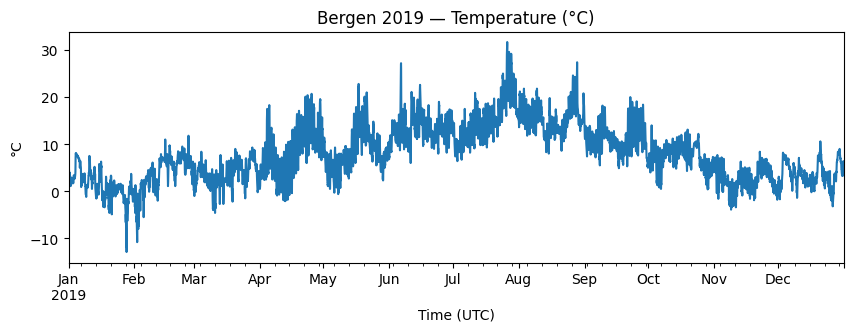

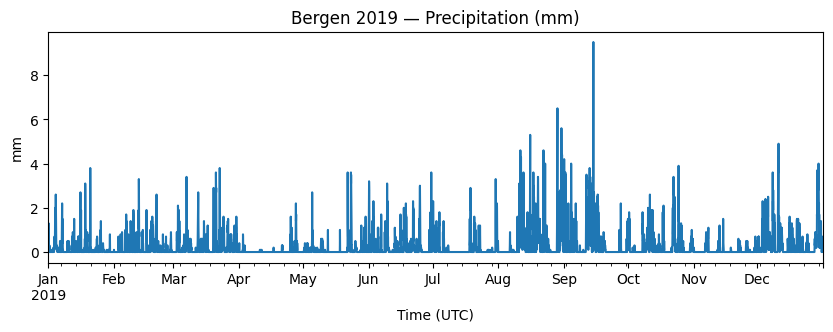

In [6]:
# Temperature vs time
ax = wx_bergen_2019.plot(x="time", y="temperature_2m", figsize=(10,3), legend=False)
ax.set_title("Bergen 2019 — Temperature (°C)"); ax.set_xlabel("Time (UTC)"); ax.set_ylabel("°C")

# Precipitation vs time
ax2 = wx_bergen_2019.plot(x="time", y="precipitation", figsize=(10,3), legend=False)
ax2.set_title("Bergen 2019 — Precipitation (mm)"); ax2.set_xlabel("Time (UTC)"); ax2.set_ylabel("mm")


In [7]:
import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

def satv_spc_plot(
    df: pd.DataFrame,
    temp_col: str = "temperature_2m",
    time_col: str = "time",
    dct_keep_frac: float = 0.05,   # fraction of lowest frequencies to DROP (high-pass)
    k_sigma: float = 3.5           # robust sigma multiplier for SPC bounds
):
    """
    Seasonally Adjusted Temperature Variations (SATV) from DCT high-pass.
    We:
      1) DCT the temperature series
      2) Zero out the lowest-frequency components (drop seasonal/trend)
      3) IDCT to get SATV (high-frequency component only)
      4) Compute robust SPC bounds using MAD
      5) Plot original temperature; color points that are out-of-bounds

    Returns:
      fig: matplotlib Figure
      summary: dict with n, n_outliers, pct_outliers, bounds
    """
    # 0) input checks
    if df.empty:
        raise ValueError("Empty DataFrame.")
    if temp_col not in df or time_col not in df:
        raise KeyError(f"Expected columns: {time_col}, {temp_col}")

    # 1) extract arrays
    t = pd.to_datetime(df[time_col], utc=True)
    s = pd.to_numeric(df[temp_col], errors="coerce").to_numpy()
    mask = np.isfinite(s)
    t = t[mask]
    s = s[mask]

    # 2) DCT → zero out LOW frequencies → IDCT
    x = dct(s, norm="ortho")
    n = len(x)
    cutoff = max(1, int(n * dct_keep_frac))  # how many low-freq coeffs to zero
    x[:cutoff] = 0.0
    satv = idct(x, norm="ortho")

    # 3) Robust SPC bounds via MAD
    med = np.median(satv)
    mad = np.median(np.abs(satv - med))
    if mad == 0:
        mad = 1e-9
    sigma = 1.4826 * mad  # MAD→sigma
    lo, hi = med - k_sigma * sigma, med + k_sigma * sigma
    is_out = (satv < lo) | (satv > hi)

    # 4) Plot temperature, highlight outliers
    fig, ax = plt.subplots(figsize=(10, 3.8))
    ax.plot(t, s, lw=0.7, label="Temperature (°C)")
    ax.scatter(t[is_out], s[is_out], s=14, label="Outliers", zorder=3)
    ax.set_title("Temperature with SPC Outliers (via SATV)")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("°C")
    ax.legend(loc="upper right")

    summary = {
        "n": int(len(s)),
        "n_outliers": int(is_out.sum()),
        "pct_outliers": float(is_out.mean() * 100),
        "bounds": (float(lo), float(hi)),
        "params": {"dct_keep_frac": float(dct_keep_frac), "k_sigma": float(k_sigma)}
    }
    return fig, summary


/var/folders/00/h17c13vd2ybg_dn_828wyhdh0000gn/T/ipykernel_40753/534523563.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'n': 8760,
 'n_outliers': 60,
 'pct_outliers': 0.684931506849315,
 'bounds': (-6.274416583123073, 6.025175013699152),
 'params': {'dct_keep_frac': 0.05, 'k_sigma': 3.5}}

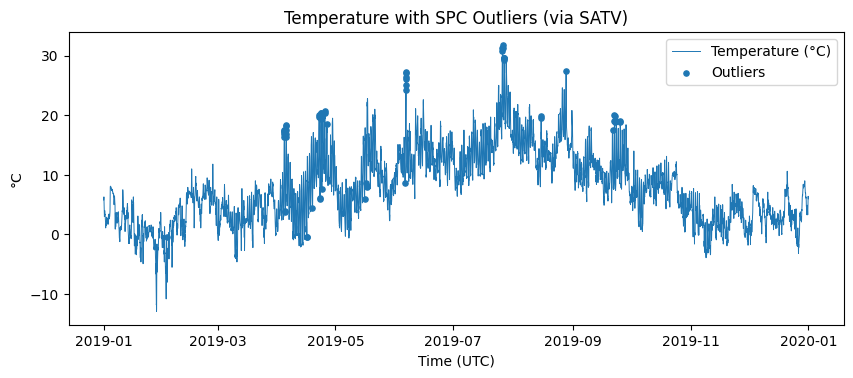

In [8]:
fig, summary = satv_spc_plot(wx_bergen_2019)
fig.show()
summary


{'n': 8760,
 'n_outliers': 176,
 'pct_outliers': 2.009132420091324,
 'bounds': (-2.218375240003556, 2.2260954995341975),
 'params': {'dct_keep_frac': 0.1, 'k_sigma': 3.0}}

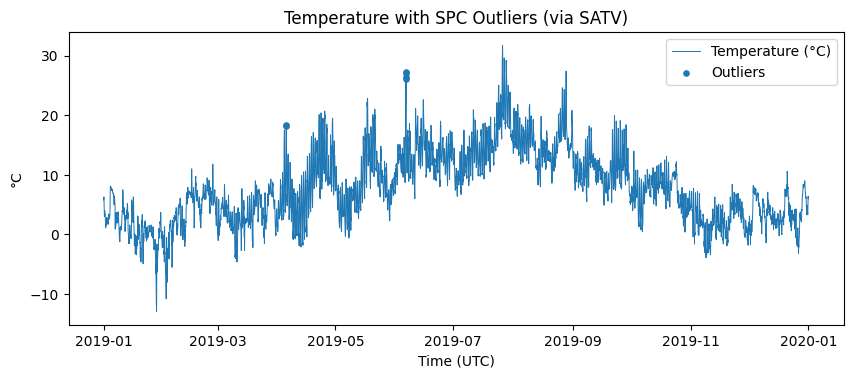

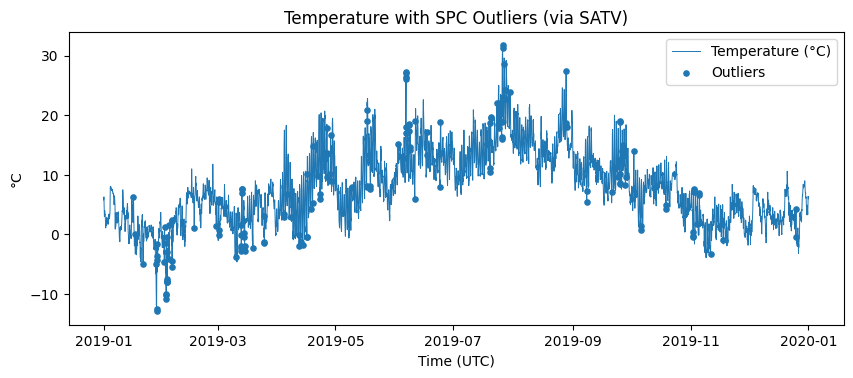

In [9]:
# Stricter bands (fewer outliers)
_, s1 = satv_spc_plot(wx_bergen_2019, dct_keep_frac=0.05, k_sigma=4.5)
s1

# Looser high-pass (detect more short-term spikes) + tighter SPC
_, s2 = satv_spc_plot(wx_bergen_2019, dct_keep_frac=0.10, k_sigma=3.0)
s2


In [12]:
%pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 1.4 MB/s eta 0:00:00m eta 0:00:01:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 5.0 MB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

def lof_precip_plot(
    df: pd.DataFrame,
    precip_col: str = "precipitation",
    time_col: str = "time",
    contamination: float = 0.01,   # target fraction of anomalies (1%)
    n_neighbors: int = 35
):
    """
    LOF anomaly detection on precipitation (1D).
    Returns:
      fig: matplotlib Figure
      summary: dict with n, n_anomalies, pct_anomalies
    """
    if df.empty:
        raise ValueError("Empty DataFrame.")
    if precip_col not in df or time_col not in df:
        raise KeyError(f"Expected columns: {time_col}, {precip_col}")

    t = pd.to_datetime(df[time_col], utc=True)
    y = pd.to_numeric(df[precip_col], errors="coerce").fillna(0.0).to_numpy()

    # LOF expects 2D array
    Z = y.reshape(-1, 1)

    # n_neighbors must be < n_samples
    nn = min(max(5, n_neighbors), max(5, len(Z) - 1))

    lof = LocalOutlierFactor(n_neighbors=nn, contamination=contamination)
    labels = lof.fit_predict(Z)        # -1 = anomaly, 1 = inlier
    is_out = labels == -1

    fig, ax = plt.subplots(figsize=(10, 3.8))
    ax.plot(t, y, lw=0.7, label="Precipitation (mm)")
    ax.scatter(t[is_out], y[is_out], s=14, label="Anomalies", zorder=3)
    ax.set_title(f"Precipitation with LOF Anomalies (cont={contamination})")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("mm")
    ax.legend(loc="upper right")

    summary = {
        "n": int(len(y)),
        "n_anomalies": int(is_out.sum()),
        "pct_anomalies": float(is_out.mean() * 100),
        "params": {"contamination": float(contamination), "n_neighbors": int(nn)}
    }
    return fig, summary


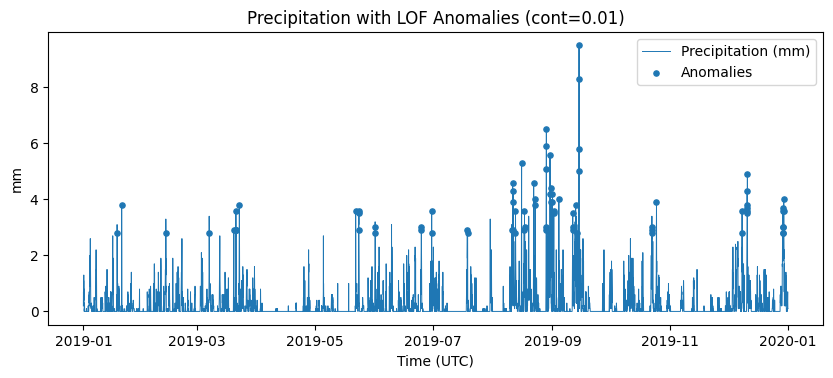

{'n': 8760,
 'n_anomalies': 80,
 'pct_anomalies': 0.91324200913242,
 'params': {'contamination': 0.01, 'n_neighbors': 35}}

In [17]:
fig_lof, sum_lof = lof_precip_plot(wx_bergen_2019)
plt.show()   # (or just leave fig_lof as the last line)
sum_lof


{'n': 8760,
 'n_anomalies': 153,
 'pct_anomalies': 1.7465753424657535,
 'params': {'contamination': 0.02, 'n_neighbors': 35}}

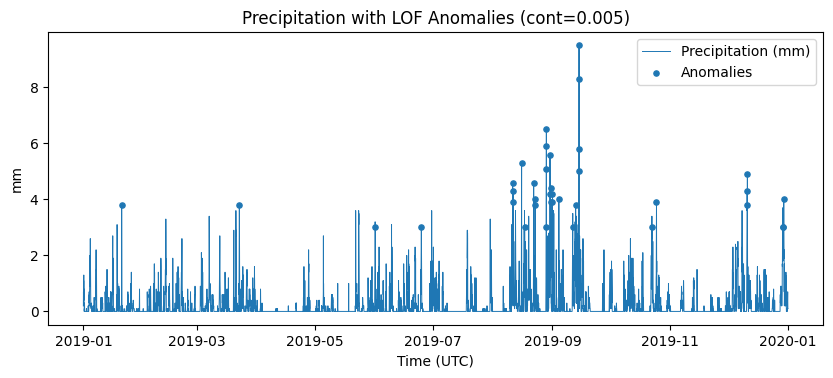

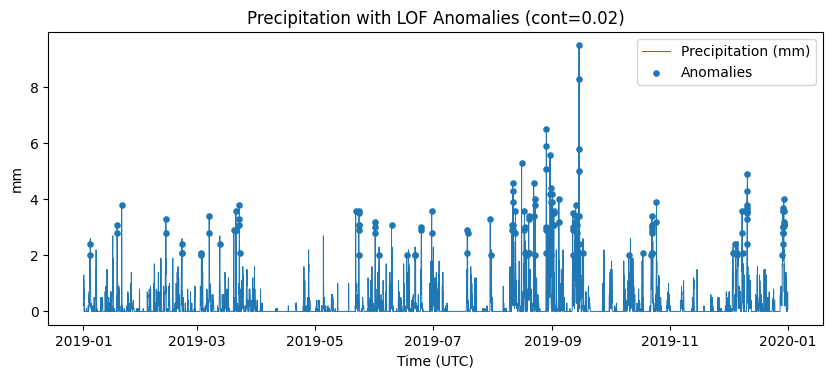

In [18]:
_, s_lof_tight = lof_precip_plot(wx_bergen_2019, contamination=0.005)  # fewer anomalies
s_lof_tight

_, s_lof_loose = lof_precip_plot(wx_bergen_2019, contamination=0.02)   # more anomalies
s_lof_loose


In [19]:
%pip install statsmodels scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 5.2 MB/s eta 0:00:0031m17.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
def load_elhub_csv(path="../elhub_prod_snapshot.csv"):
    df = pd.read_csv(path, parse_dates=["startTime"])
    df = df.sort_values("startTime")
    # Keep needed columns only
    cols = ["priceArea","productionGroup","startTime","quantityKwh"]
    return df[cols]
    
elhub = load_elhub_csv()
elhub.head()


,priceArea,productionGroup,startTime,quantityKwh
0,NO5,other,2025-09-22 10:00:00+00:00,58.777
17016,NO3,solar,2025-09-22 10:00:00+00:00,1961.927
1368,NO5,*,2025-09-22 10:00:00+00:00,0.156
16332,NO4,hydro,2025-09-22 10:00:00+00:00,1810739.400
2052,NO3,thermal,2025-09-22 10:00:00+00:00,20500.460


In [21]:
def stl_decompose(
    df: pd.DataFrame,
    price_area: str = "NO1",
    production_group: str = "hydro",
    period: int = 24*7,           # period length (hours)
    seasonal: int = 13,           # seasonal smoother
    trend: int = 301,             # trend smoother
    robust: bool = True           # robust True/False
):
    """
    STL on hourly production series.
    """
    s = (df[(df["priceArea"]==price_area) & (df["productionGroup"]==production_group)]
         .set_index("startTime")["quantityKwh"]
         .asfreq("H")
         .interpolate())
    
    res = STL(s, period=int(period), seasonal=int(seasonal), trend=int(trend), robust=robust).fit()
    fig = res.plot()
    fig.suptitle(f"STL — area={price_area}, group={production_group}, period={period}")
    return fig


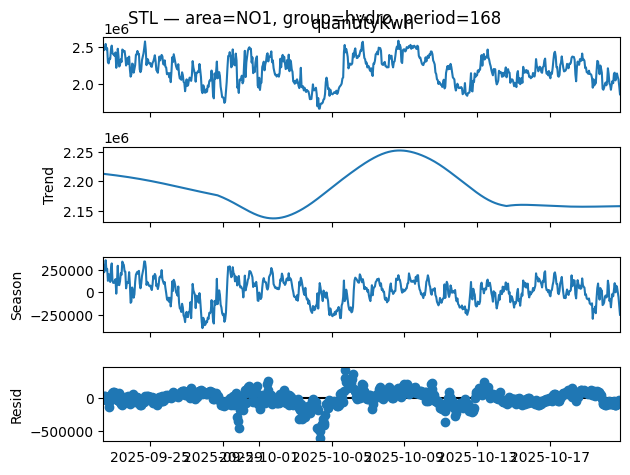

In [22]:
fig_stl = stl_decompose(elhub)  # defaults: NO1/hydro
plt.show()


In [23]:
def prod_spectrogram(
    df: pd.DataFrame,
    price_area: str = "NO1",
    production_group: str = "hydro",
    window_len: int = 24*14,     # hours per segment
    overlap: float = 0.5         # 0..1
):
    """
    Spectrogram on hourly production series.
    """
    s = (df[(df["priceArea"]==price_area) & (df["productionGroup"]==production_group)]
         .set_index("startTime")["quantityKwh"]
         .asfreq("H")
         .interpolate())
    
    nperseg = int(window_len)
    noverlap = int(nperseg * float(overlap))
    f, tt, Sxx = spectrogram(s.values, fs=1.0, nperseg=nperseg, noverlap=noverlap, scaling="density")

    fig, ax = plt.subplots(figsize=(10,4))
    im = ax.pcolormesh(tt, f, 10*np.log10(Sxx + 1e-12), shading="auto")
    ax.set_title(f"Spectrogram — area={price_area}, group={production_group}")
    ax.set_xlabel("Window index")
    ax.set_ylabel("Frequency (cycles/hour)")
    fig.colorbar(im, ax=ax, label="Power (dB)")
    return fig


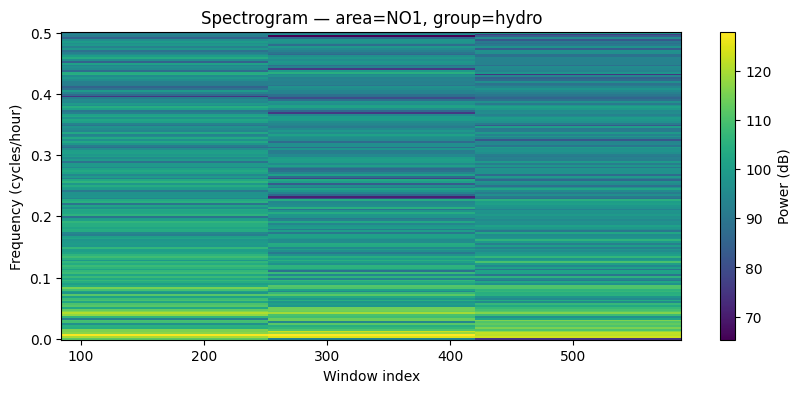

In [24]:
fig_spec = prod_spectrogram(elhub)  # defaults
plt.show()


Project Log (300–500 words)

This part of the project focused on data quality, and the work built directly on top of the structures and functions developed in the previous parts of the IND320 project. In this phase, the main focus was to retrieve ERA5 reanalysis weather data through the open-meteo API, apply data quality techniques, and integrate the new functionality properly into the Streamlit application. The main cities used represent the electricity price areas in Norway, and the Streamlit application was updated to fetch the required data dynamically based on the selected area and with the year fixed to 2021 according to the project specification.

From the Jupyter Notebook perspective, work started by creating a general-purpose function to download ERA5 weather data using requests, with the same variables that were used earlier in the CSV file version of the project. Data exploration included initial time series inspection and generation of basic reference plots. The temperature data was then processed through a DCT-based high-pass filter to obtain the seasonally adjusted temperature variations (SATV), which formed the basis for outlier detection. SPC boundaries were calculated using robust median absolute deviation statistics, and outliers were highlighted directly in the temperature timeline plot. In addition, precipitation anomalies were detected using the Local Outlier Factor method with adjustable contamination proportions and number of neighbors. Both methods were wrapped into parameterised functions to ensure reusability.

For production data (elhub), STL decomposition using LOESS smoothing and spectrogram-based frequency analysis were performed. These were both developed as separate functions in the Notebook and later integrated into the Streamlit app under a new tab structure, where STL and spectrogram were placed on one new page, while SPC (temperature) and LOF (precipitation) were placed on another. The assignment 2 layout correction was also implemented, where the main plots on the production page are placed side-by-side rather than above each other.

Version control discipline was followed by using branches before merging into main, and all Notebook cells were executed before export to ensure reproducibility, clarity and transparency.

AI Usage

AI assistance (ChatGPT GPT-5) was used for syntax clarification, debugging small code issues, and improving clarity of written descriptions. All methodological decisions and implementation were done independently.